In [1]:
%pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
import peakdetect
from runmainsim import *
import tvbsim

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


# 1. Set Up Simulation Configuration First
Here, set everything from the ez region, connectivity, node model, coupling, monitors, integrator, and parameters.

In [2]:
def renamefiles(patient, project_dir):
    ####### Initialize files needed to 
    # convert seeg.xyz to seeg.txt file
    sensorsfile = os.path.join(project_dir, "seeg.xyz")
    newsensorsfile = os.path.join(project_dir, "seeg.txt")
    try:
        os.rename(sensorsfile, newsensorsfile)
    except:
        print "Already renamed seeg.xyz possibly!"

    # convert gain_inv-square.mat file into gain_inv-square.txt file
    gainmatfile = os.path.join(project_dir, "gain_inv-square.mat")
    newgainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
    try:
        os.rename(gainmatfile, newgainmatfile)
    except:
        print "Already renamed gain_inv-square.mat possibly!"    

In [4]:
patients = ['id001_ac', 'id002_cj', 'id014_rb']
patients = ['id014_rb']
patients = ['id001_ac']
for patient in patients:
    print patient
#     patient='cj'
    # 1000 = 1 second
    samplerate = 1000 # Hz
    sim_length = 240*samplerate

    ezregion = ['ctx-lh-bankssts', 'ctx-lh-cuneus']
    ezregion = ['ctx-lh-bankssts']
#     ezregion = []
    pzregion = ['ctx-lh-cuneus']
    pzregion = []

    outputdir = os.path.join('/Users/adam2392/Documents/pydata/tvb_forwardsim/', patient)
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    filename = os.path.join(outputdir, patient+'_nonmovedsim_nez'+str(len(ezregion))+\
                                        '_npz'+str(len(pzregion))+'.npz')

    period = 1
    # x0c value = -2.05
    x0norm=-2.5
    x0ez=-1.6
    x0pz=-2.04
    
    # intialized hard coded parameters
    epileptor_r = 0.0002       # Temporal scaling in the third state variable
    epiks = -0.5                 # Permittivity coupling, fast to slow time scale
    epitt = 0.05               # time scale of simulation
    epitau = 10                # Temporal scaling coefficient in fifth st var

    # depends on epileptor variables of interest: it is where the x2-y2 var is
    varindex = [1]
    
    # parameters for heun-stochastic integrator
    heun_ts = 0.05
    noise_cov = np.array([0.001, 0.001, 0.,\
                    0.0001, 0.0001, 0.])
    
    root_dir = os.getcwd()
    project_dir = os.path.join(root_dir, "metadata/"+patient)
    print "Project directory for meta data is : ", project_dir
    print "File to be saved is: ", filename
    renamefiles(patient, project_dir)
    
    ####### Initialize files needed to 
    # convert seeg.xyz to seeg.txt file
    sensorsfile = os.path.join(project_dir, "seeg.txt")
    # convert gain_inv-square.mat file into gain_inv-square.txt file
    gainmatfile = os.path.join(project_dir, "gain_inv-square.txt")
    
    confile = os.path.join(project_dir, "connectivity.zip")
    ####################### 1. Structural Connectivity ########################
    con = initconn(confile)
    # determine what the regions are for this certain parcellation
    # and get the ez indices, pz indices desired
    regions = con.region_labels
    ezindices, pzindices = getindexofregion(regions, ezregion, pzregion)
    num_regions = len(regions)
    
    ####################### 2. Neural Mass Model @ Nodes ######################
    epileptors = initepileptor(epileptor_r, epiks, epitt, epitau, x0norm, \
                              x0ez, x0pz, ezindices, pzindices, num_regions)    
    ####################### 3. Integrator for Models ##########################
    heunint = initintegrator(heun_ts, noise_cov)
    ################## 4. Difference Coupling Between Nodes ###################
    coupl = initcoupling(a=1.)
    ############## 5. Import Sensor XYZ, Gain Matrix For Monitors #############
    monitors = initmonitors(period, sensorsfile, gainmatfile, varindex)
    
    # extract the seeg_xyz coords and the region centers
#     seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
#     region_centers = con.centres
    
#     # find the closest contact index and distance
#     seeg_index, distance = tvbsim.util.findclosestcontact(ezindices, region_centers, seeg_xyz)
    
#     try:
#         # get the modified seeg xyz and gain matrix
#         modseeg = tvbsim.util.movecontact(seeg_xyz, region_centers, ezindices, seeg_index)
#         modgain = tvbsim.util.simplest_gain_matrix(modseeg.as_matrix(), region_centers)
        
#         # modify the config of the monitors
#         monitors[1].sensors.locations = modseeg
#         monitors[1].gain = modgain
#     except:
#         print "not modifying seeg xyz and gain matrix"
    
    # get initial conditions and then setup entire simulation configuration
    initcond = initconditions(x0norm, num_regions)
    sim, configs = setupconfig(epileptors, con, coupl, heunint, monitors, initcond)

id014_rb
Project directory for meta data is :  /Users/adam2392/Documents/tvb/metadata/id014_rb
File to be saved is:  /Users/adam2392/Documents/pydata/tvb_forwardsim/id014_rb/id014_rb_sim_nez1_npz1.npz
Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
is left


 movecontact function summary: 

Closest contact to ezregion:  [[-45.3305 -31.7053  -4.7786]]  is  H'13
That is located at:            x      y    z
H'13 -47.69 -17.06  0.9
It will move:  [-2.359499999999997, 14.645300000000002, 5.6786000000000003]
New location after movement is             x        y       z
H'13 -45.3305 -31.7053 -4.7786





In [5]:
times, epilepts, seegts = runsim(sim, sim_length)

######################## POST PROCESSING #################################
# post process by cutting off first 5 seconds of simulation
# for now, don't, since intiial conditions
times, epits, seegts, zts = postprocts(epilepts, seegts, times)

# get the onset, offset times
onsettimes = None
offsettimes = None
try:
    onsettimes, offsettimes = findonsetoffset(zts[ezindices, :].squeeze())
except:
    print "Still not working..."

######################## SAVING ALL DATA #################################
regions = configs.connectivity.region_labels
# Save files
meta = {
    'x0ez':x0ez,
    'x0pz':x0pz,
    'x0norm':x0norm,
    'regions': regions,
    'regions_centers': configs.connectivity.centres,
    'seeg_contacts': configs.monitors[1].sensors.labels,
    'seeg_xyz': configs.monitors[1].sensors.locations,
    'ez': regions[ezindices],
    'pz': regions[pzindices],
    'ezindices': ezindices,
    'pzindices': pzindices,
    'onsettimes':onsettimes,
    'offsettimes':offsettimes,
    'patient':patient,
}

# save tseries
np.savez(filename, epits=epits, seegts=seegts, \
         times=times, zts=zts, metadata=meta)

# 2. Visualize Epileptor and SEEG Simulated Results

In [78]:
####################### 1. Structural Connectivity ########################
con = initconn(confile)
# determine what the regions are for this certain parcellation
# and get the ez indices, pz indices desired
regionlabels = con.region_labels
regioncentres = con.centres
ezindices, pzindices = getindexofregion(regions, ezregion, pzregion)
num_regions = len(regions)
    
# get xyz coords of region centres
xreg, yreg, zreg = regioncentres.T
numregions = regioncentres.shape[0]
righthemisphere_x = xreg[:numregions/2]
righthemisphere_y = yreg[:numregions/2]
lefthemisphere_x = xreg[numregions/2:]
lefthemisphere_y = yreg[numregions/2:]
    
# get xyz data for cortical surface
project_dir = os.path.join(root_dir, "metadata/"+patient)
cort_surf = surfaces.CorticalSurface.from_file(source_file=os.path.join(project_dir, "surface_cort.zip"))
cort_surf.configure()
cort_surf.summary_info
x_cort, y_cort, z_cort = cort_surf.vertices.T
    
# SEEG location as red 
seeg_xyz = tvbsim.util.extractseegxyz(sensorsfile)
xs, ys, zs = seeg_xyz.values.T # SEEG coordinates --------> (RB)'s electrodes concatenated
numcontacts = seeg_xyz.shape[0]

In [85]:
import re
elect = []
dipole = []
contacts = seeg_xyz.index

for element in range(0,contacts.shape[0]):
    #print ffff[i1_s]
    kpm = np.array(re.match("([A-Z]+[a-z]*[']*)([0-9]+)", contacts[element]).groups())
    #print kpm[0]  
    #print kpm[1]  
    #print int(kpm[1])
    elect.append(kpm[0])
    dipole.append(int(kpm[1]))
    
    
find_0 = []
nbr_contacts = []
for element_1 in range(0, len(dipole)):
    if dipole[element_1] == 1:
        find_0.append(element_1)
    
#print find_0
##### find_0  ---> index of dipole equal to 0

##### N.B

###### Number of electrodes is : len(find_0)
###### Number of contacts per an electrode i is nbr_contacts[i+1]

for element_2 in range(0, 2):
    nbr_contacts.append(find_0[element_2+1]-find_0[element_2])

for element_3 in range(2, len(find_0)-1):
    nbr_contacts.append(find_0[element_3+1]-find_0[element_3])

nbr_contacts.append(len(contacts)- find_0[len(find_0)-1])
print "Nbre_contacts_per_electrode:", nbr_contacts

#########################################################
#########################################################

print "Nbre_electrodes:", len(nbr_contacts)

incr_cont = np.zeros((len(nbr_contacts)), int)
incr_cont[0] = 0

for element_4 in range(0, len(nbr_contacts)):
    incr_cont[element_4] = incr_cont[element_4-1] + nbr_contacts[element_4]

print "Ending Index of electrodes:", incr_cont # To plot each electrode with diff color
nCols_new = len(nbr_contacts)

color_new = ['peru', 'dodgerblue', 'slategrey', 
             'skyblue', 'springgreen', 'fuchsia', 'limegreen', 
             'orangered',  'gold', 'crimson', 'teal', 'blueviolet', 'black', 'cyan', 'lightseagreen',
             'lightpink', 'red', 'indigo', 'mediumorchid', 'mediumspringgreen']

Nbre_contacts_per_electrode: [14, 14, 9, 2, 4, 9, 9, 9]
Nbre_electrodes: 8
Ending Index of electrodes: [14 28 37 39 43 52 61 70]


<IPython.core.display.Javascript object>


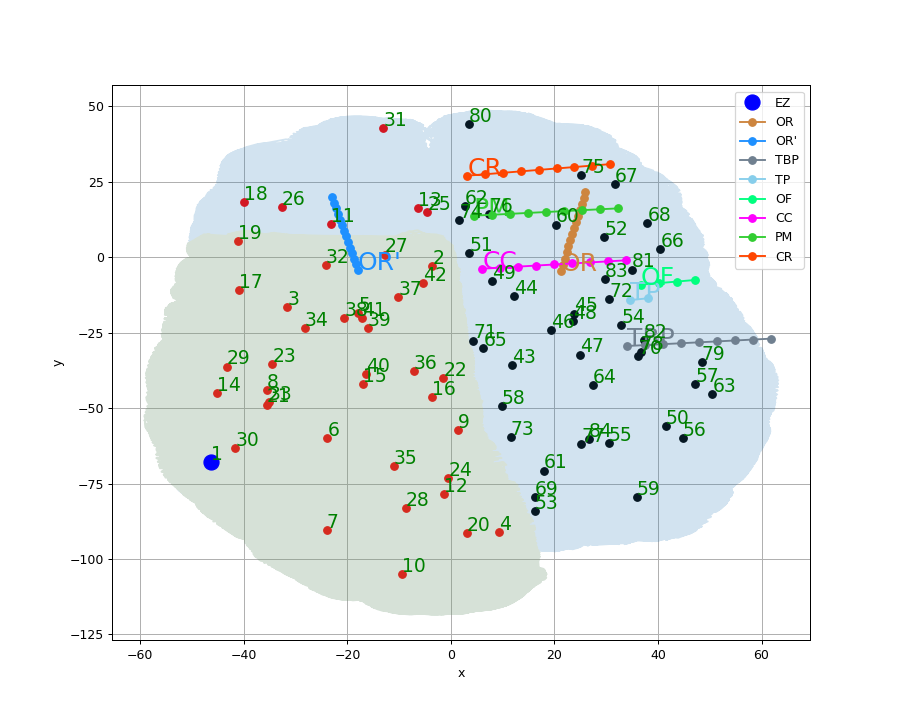

['ctx-lh-bankssts']


In [86]:
################# PLOTTING #################
# visualize brain cross-section
brainfig = plt.figure(figsize=(10,8))

############################ Plot Colored Circles for Regions XY Coords ############################
# divide into equal regions for left/right hemisphere
plt.plot(righthemisphere_x, righthemisphere_y, 'ro')
#and black for Left Hemisphere
plt.plot(lefthemisphere_x, lefthemisphere_y, 'ko')

#################################### Plot surface vertices  ###################################    
plt.plot(x_cort, y_cort, alpha=0.2) 
contourr = -4600
plt.plot(x_cort[: contourr + len(x_cort)//2], y_cort[: contourr + len(x_cort)//2], 'gold', alpha=0.1) 

#################################### label regions EZ ###################################    
print regionlabels[ezindices]
plot(xreg[ezindices] , yreg[ezindices], 'bo', markersize=12, label="EZ")  ### EZ

#################################### Elecrodes Implantation  ###################################    
ii = 0
# get number of contacts per electrode
incr_cont = np.zeros((len(nbr_contacts)), int)
incr_cont[0] = 0

for element_4 in range(0, len(nbr_contacts)):
    incr_cont[element_4] = incr_cont[element_4-1] + nbr_contacts[element_4]

# plot the contact points
plt.plot(xs[:incr_cont[ii]], ys[:incr_cont[ii]], 
          color_new[ii] , marker = 'o', label= elect[ii])

# add label at the first contact for electrode
plt.text(xs[0], ys[0],  str(elect[ii]), color = color_new[ii], fontsize = 20)


for ii in range(1,nCols_new):
    plt.plot(xs[incr_cont[ii-1]:incr_cont[ii]], ys[incr_cont[ii-1]:incr_cont[ii]], 
         color_new[ii] , marker = 'o', label= elect[incr_cont[ii-1]])
    plt.text(xs[incr_cont[ii-1]], ys[incr_cont[ii-1]],  str(elect[incr_cont[ii-1]]), color = color_new[ii], fontsize = 20)

for er in range(numregions):
    plt.text(xreg[er] , yreg[er] + 0.7, str(er+1), color = 'g', fontsize = 15)

xlabel('x')
ylabel('y')

plt.grid(True)
plt.legend()
plt.show()